In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb


/home/daniel/projects_repo/masters_project/.venv/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/daniel/projects_repo/masters_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style = 'darkgrid')

data loading and preprocessing


In [4]:
data = pd.read_excel("../data/raw/wind_speed_2024.xlsx", index_col=0)
data.head()

,Data,Alagoas,Paraíba,Pernambuco,Rio Grande do Norte,Rio Grande do Sul,Santa Catarina,Sergipe
0,1980-01-01,7.130379,7.805494,7.073644,8.042703,7.142046,4.829946,6.759042
1,1980-02-01,6.508296,6.667070,6.375263,6.571027,6.761244,4.829477,6.288946
2,1980-03-01,6.994155,7.669710,7.040406,7.427828,6.182708,4.329960,6.846870
3,1980-04-01,7.048815,7.754765,7.136591,7.765971,7.115378,4.739272,6.818778
4,1980-05-01,7.139307,8.406832,7.499776,8.620216,6.427715,4.527883,6.894530


In [5]:
columns = data.drop(columns='Data').columns.to_list()
columns

['Alagoas',
 'Paraíba',
 'Pernambuco',
 'Rio Grande do Norte',
 'Rio Grande do Sul',
 'Santa Catarina',
 'Sergipe']

In [6]:
def pre_process_data(data: pd.DataFrame, columns: list = columns):
    """
    Setting dataframe according to Statsforecast
	"""

    data = pd.melt(data, id_vars=['Data'],
                   var_name='unique_id',
                   value_vars=columns,
                   value_name='y')
    data = data.rename(columns={"Data":'ds'})
    return data

In [7]:
train_data = pre_process_data(test_data.iloc[:-60])
test_data = pre_process_data(test_data.iloc[-60:])

In [8]:
train_data

,ds,unique_id,y
0,1980-01-01,Alagoas,7.130379
1,1980-02-01,Alagoas,6.508296
2,1980-03-01,Alagoas,6.994155
3,1980-04-01,Alagoas,7.048815
4,1980-05-01,Alagoas,7.139307
...,...,...,...
3355,2019-08-01,Sergipe,7.483191
3356,2019-09-01,Sergipe,7.258875
3357,2019-10-01,Sergipe,7.339849
3358,2019-11-01,Sergipe,7.176664


In [9]:
test_data

,ds,unique_id,y
0,2020-01-01,Alagoas,6.672386
1,2020-02-01,Alagoas,6.389696
2,2020-03-01,Alagoas,5.739236
3,2020-04-01,Alagoas,6.203149
4,2020-05-01,Alagoas,6.494120
...,...,...,...
415,2024-08-01,Sergipe,7.246667
416,2024-09-01,Sergipe,7.055333
417,2024-10-01,Sergipe,6.870000
418,2024-11-01,Sergipe,7.030667


Training model

In [10]:
models = [
    AutoARIMA(season_length=12, allowmean=True)
]

In [ ]:
sf = StatsForecast(models = models, freq = 'MS', n_jobs= -1)

In [ ]:
sf.fit(train_data)

StatsForecast(models=[AutoARIMA])

In [13]:
fitted_models = sf.fitted_
model_params = {}

for idx, model_object in enumerate(fitted_models):
    # Acessa o objeto de modelo interno
    model = model_object[0].model_
    
    # Extrai a string de parâmetros (p, d, q) e os sazonais (P, D, Q, m)
    params_string = arima_string(model)
    
    # Armazena em um dicionário, usando o unique_id como chave
    unique_id = train_data['unique_id'].unique()[idx]
    model_params[unique_id] = params_string

# 4. Exibir os parâmetros
for unique_id, params in model_params.items():
    print(f"Parâmetros para a série '{unique_id}': {params}")

Parâmetros para a série 'Alagoas': ARIMA(2,0,0)(0,1,1)[12]                   
Parâmetros para a série 'Paraíba': ARIMA(1,0,3)(0,1,1)[12]                   
Parâmetros para a série 'Pernambuco': ARIMA(0,0,2)(0,1,1)[12]                   
Parâmetros para a série 'Rio Grande do Norte': ARIMA(1,0,1)(0,1,1)[12]                   
Parâmetros para a série 'Rio Grande do Sul': ARIMA(1,0,0)(2,0,0)[12] with non-zero mean
Parâmetros para a série 'Santa Catarina': ARIMA(1,0,0)(2,0,0)[12] with non-zero mean
Parâmetros para a série 'Sergipe': ARIMA(2,0,0)(0,1,1)[12]                   


In [15]:
sf.forecast(df = train_data, h= 1,fitted=True)

,unique_id,ds,AutoARIMA
0,Alagoas,2020-01-01,7.295456
1,Paraíba,2020-01-01,7.611765
2,Pernambuco,2020-01-01,7.068127
3,Rio Grande do Norte,2020-01-01,7.746776
4,Rio Grande do Sul,2020-01-01,7.317028
5,Santa Catarina,2020-01-01,4.997393
6,Sergipe,2020-01-01,7.005477


In [16]:
fitted_arima_values = sf.forecast_fitted_values()
fitted_arima_values

,unique_id,ds,y,AutoARIMA
0,Alagoas,1980-01-01,7.130379,7.123249
1,Alagoas,1980-02-01,6.508296,6.501788
2,Alagoas,1980-03-01,6.994155,6.987161
3,Alagoas,1980-04-01,7.048815,7.041766
4,Alagoas,1980-05-01,7.139307,7.132168
...,...,...,...,...
3355,Sergipe,2019-08-01,7.483191,7.315003
3356,Sergipe,2019-09-01,7.258875,7.547835
3357,Sergipe,2019-10-01,7.339849,7.447336
3358,Sergipe,2019-11-01,7.176664,7.403502


In [17]:
fitted_arima_values['residual'] = fitted_arima_values['y'] - fitted_arima_values['AutoARIMA']
fitted_arima_values

,unique_id,ds,y,AutoARIMA,residual
0,Alagoas,1980-01-01,7.130379,7.123249,0.007130
1,Alagoas,1980-02-01,6.508296,6.501788,0.006508
2,Alagoas,1980-03-01,6.994155,6.987161,0.006994
3,Alagoas,1980-04-01,7.048815,7.041766,0.007049
4,Alagoas,1980-05-01,7.139307,7.132168,0.007139
...,...,...,...,...,...
3355,Sergipe,2019-08-01,7.483191,7.315003,0.168188
3356,Sergipe,2019-09-01,7.258875,7.547835,-0.288960
3357,Sergipe,2019-10-01,7.339849,7.447336,-0.107488
3358,Sergipe,2019-11-01,7.176664,7.403502,-0.226837


In [18]:
train_data_residuals = fitted_arima_values[['ds', 'unique_id', 'residual']]
train_data_residuals.head()

,ds,unique_id,residual
0,1980-01-01,Alagoas,0.007130
1,1980-02-01,Alagoas,0.006508
2,1980-03-01,Alagoas,0.006994
3,1980-04-01,Alagoas,0.007049
4,1980-05-01,Alagoas,0.007139


In [19]:
models2 = [RandomForestRegressor(random_state=42),
           lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity = -1)]

In [20]:
sf2 = MLForecast(
    models=models2,
    freq='MS',
    lags = list(range(1,13))
)

In [21]:
sf2.fit(train_data_residuals,
        target_col='residual')

MLForecast(models=[RandomForestRegressor, LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [22]:
forecasted_residuals = sf2.predict(h=60)

In [23]:
forecasted_residuals

,unique_id,ds,RandomForestRegressor,LGBMRegressor
0,Alagoas,2020-01-01,0.203300,0.084911
1,Alagoas,2020-02-01,0.008813,0.132884
2,Alagoas,2020-03-01,-0.141260,-0.008045
3,Alagoas,2020-04-01,0.077458,-0.069490
4,Alagoas,2020-05-01,0.006172,0.063083
...,...,...,...,...
415,Sergipe,2024-08-01,-0.021985,0.083557
416,Sergipe,2024-09-01,0.127656,0.031408
417,Sergipe,2024-10-01,0.060711,0.039026
418,Sergipe,2024-11-01,0.014494,0.027129


In [24]:
forecasted_arima = sf.predict(h=60)

In [25]:
forecasted_arima

,unique_id,ds,AutoARIMA
0,Alagoas,2020-01-01,7.295456
1,Alagoas,2020-02-01,7.088995
2,Alagoas,2020-03-01,6.760491
3,Alagoas,2020-04-01,6.611134
4,Alagoas,2020-05-01,6.847009
...,...,...,...
415,Sergipe,2024-08-01,7.354240
416,Sergipe,2024-09-01,7.516204
417,Sergipe,2024-10-01,7.450256
418,Sergipe,2024-11-01,7.401755


In [26]:
predictions = test_data.copy()

In [29]:
predictions['y_hat_rf'] = forecasted_arima['AutoARIMA'] + forecasted_residuals['RandomForestRegressor']
predictions['y_hat_lgbm'] = forecasted_arima['AutoARIMA'] + forecasted_residuals['LGBMRegressor']
predictions

,ds,unique_id,y,y_hat_rf,y_hat_lgbm
0,2020-01-01,Alagoas,6.672386,7.498756,7.380367
1,2020-02-01,Alagoas,6.389696,7.097808,7.221879
2,2020-03-01,Alagoas,5.739236,6.619232,6.752446
3,2020-04-01,Alagoas,6.203149,6.688591,6.541644
4,2020-05-01,Alagoas,6.494120,6.853181,6.910092
...,...,...,...,...,...
415,2024-08-01,Sergipe,7.246667,7.332255,7.437797
416,2024-09-01,Sergipe,7.055333,7.643860,7.547612
417,2024-10-01,Sergipe,6.870000,7.510966,7.489282
418,2024-11-01,Sergipe,7.030667,7.416249,7.428884


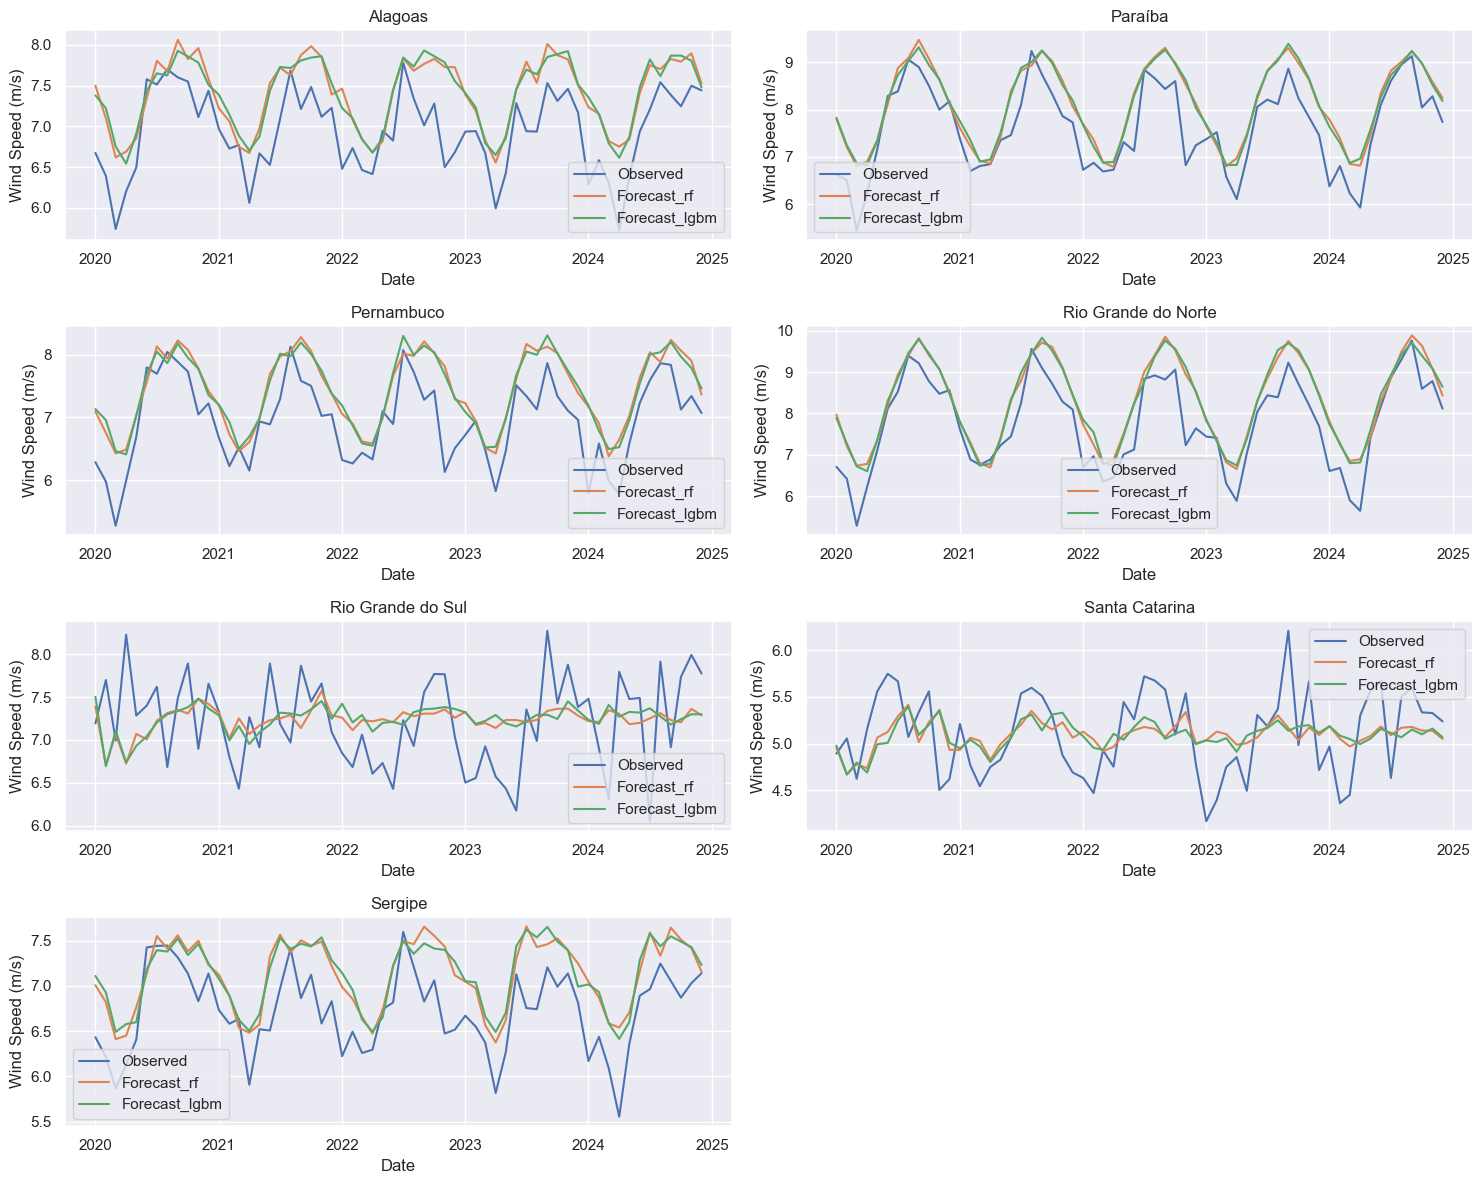

In [31]:
states = ['Alagoas', 'Paraíba', 'Pernambuco', 'Rio Grande do Norte', 'Rio Grande do Sul', 'Santa Catarina', 'Sergipe']
n_states = len(states)
n_cols = 2
n_rows = int(np.ceil(n_states / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axs = axs.flatten()

for i, state in enumerate(states):
	axs[i].plot(predictions['ds'][-60:], 
			 predictions[predictions['unique_id'] == state]['y'],
			 label = "Observed")
	axs[i].plot(predictions['ds'][-60:], 
			 predictions[predictions['unique_id'] == state]['y_hat_rf'],
			 label = "Forecast_rf")
	axs[i].plot(predictions['ds'][-60:], 
			 predictions[predictions['unique_id'] == state]['y_hat_lgbm'],
			 label = "Forecast_lgbm")
	axs[i].set_title(f'{state}')
	axs[i].set_ylabel('Wind Speed (m/s)')
	axs[i].set_xlabel('Date')
	axs[i].legend()

for j in range(i + 1, len(axs)):
	fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [32]:
sf3 = MLForecast(
    models=models2,
    freq='MS',
    lags = list(range(1,13))
)

In [35]:
sf3.fit(train_data, fitted=True)

MLForecast(models=[RandomForestRegressor, LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [46]:
predictions2 = sf3.predict(h=60)
predictions2.rename(columns={'RandomForestRegressor':'y_hat_rf',
                     'LGBMRegressor':'y_hat_lgbm'}, inplace = True)


In [47]:
predictions2['y'] = predictions['y']

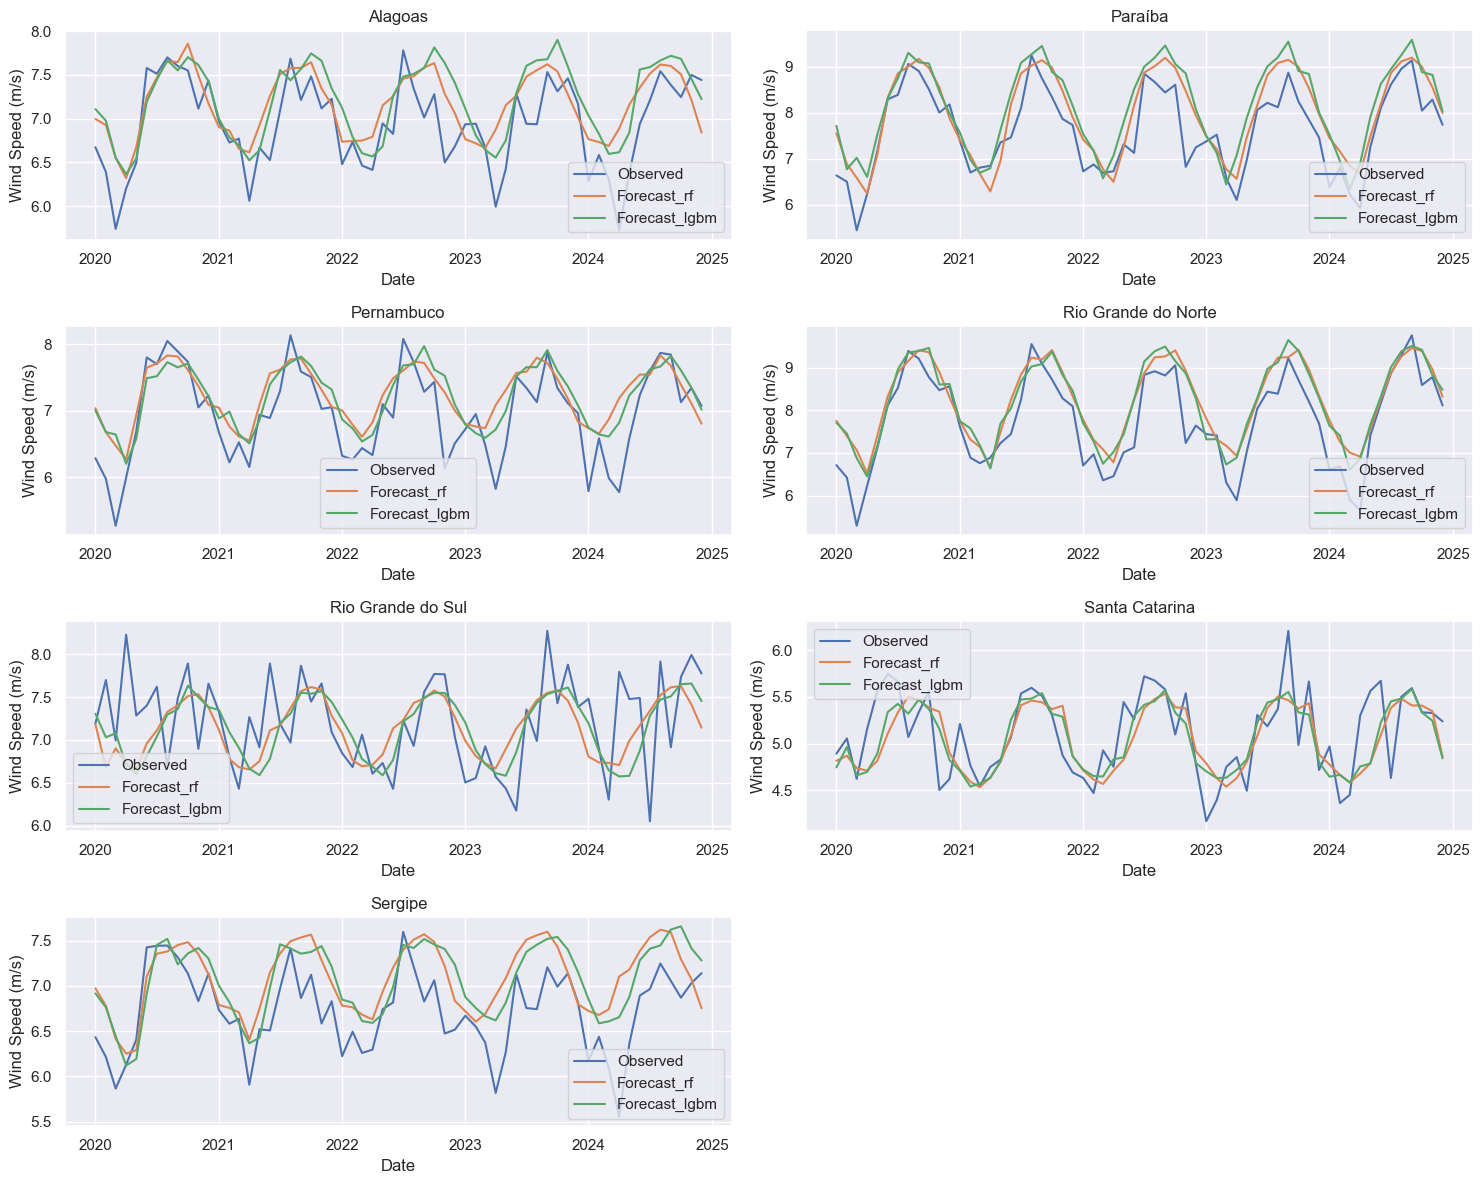

In [48]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axs = axs.flatten()

for i, state in enumerate(states):
	axs[i].plot(predictions2['ds'][-60:], 
			 predictions2[predictions2['unique_id'] == state]['y'],
			 label = "Observed")
	axs[i].plot(predictions2['ds'][-60:], 
			 predictions2[predictions2['unique_id'] == state]['y_hat_rf'],
			 label = "Forecast_rf")
	axs[i].plot(predictions2['ds'][-60:], 
			 predictions2[predictions2['unique_id'] == state]['y_hat_lgbm'],
			 label = "Forecast_lgbm")
	axs[i].set_title(f'{state}')
	axs[i].set_ylabel('Wind Speed (m/s)')
	axs[i].set_xlabel('Date')
	axs[i].legend()

for j in range(i + 1, len(axs)):
	fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [98]:
from utilsforecast.losses import (rmse, mae)

In [173]:
rmse_arima_hybrid , mae_arima_hybrid = (rmse(predictions, models =['y_hat_rf', 'y_hat_lgbm']) , 
 mae(predictions, models =['y_hat_rf', 'y_hat_lgbm']))
rmse_ml , mae_ml = (rmse(predictions2, models =['y_hat_rf', 'y_hat_lgbm']) , 
 mae(predictions, models =['y_hat_rf', 'y_hat_lgbm']))

In [174]:
rmse_arima_hybrid.rename(columns={"y_hat_rf": 'arima_rf',
                                  'y_hat_lgbm':'arima_lgbm'}, inplace = True)
mae_arima_hybrid.rename(columns={"y_hat_rf": 'arima_rf',
                                  'y_hat_lgbm':'arima_lgbm'}, inplace = True)

In [175]:
rmse_ml.rename(columns={"y_hat_rf": 'rf',
                                  'y_hat_lgbm':'lgbm'}, inplace = True)
mae_ml.rename(columns={"y_hat_rf": 'rf',
                                  'y_hat_lgbm':'lgbm'}, inplace = True)

In [101]:
from sklearn.metrics import root_mean_squared_error as rrmse
from sklearn.metrics import mean_absolute_error as mmae

In [172]:
rmse_arima = {}
for state in states:
    a = rrmse(forecasted_arima[forecasted_arima['unique_id']==state]['y'], 
              forecasted_arima[forecasted_arima['unique_id']==state]['ARIMA'])
    rmse_arima[state] = a
rmse_arima = pd.Series(rmse_arima)
rmse_arima.reset_index()
rmse_arima = pd.DataFrame(rmse_arima)
rmse_arima = rmse_arima.reset_index()
rmse_arima.rename(columns={"index": 'unique_id',
                                         0: 'arima'}, inplace=True)


In [158]:
mae_arima = {}
for state in states:
    a = rrmse(forecasted_arima[forecasted_arima['unique_id']==state]['y'], 
              forecasted_arima[forecasted_arima['unique_id']==state]['ARIMA'])
    mae_arima[state] = a
mae_arima = pd.Series(mae_arima)
mae_arima.reset_index()
mae_arima = pd.DataFrame(mae_arima)
mae_arima = mae_arima.reset_index()
mae_arima.rename(columns={"index": 'unique_id',
                                         0: 'arima'}, inplace=True)

In [226]:
df_temp = pd.merge(rmse_arima, rmse_arima_hybrid,
                   how = 'inner',
                   on = 'unique_id')
df_temp

rmse_erros = pd.merge(df_temp, rmse_ml,
                      how = 'inner',
                      on = 'unique_id')

rmse_erros

,unique_id,arima,arima_rf,arima_lgbm,rf,lgbm
0,Alagoas,0.521798,0.559427,0.553546,0.410033,0.422606
1,Paraíba,0.609400,0.651908,0.642851,0.552491,0.689534
2,Pernambuco,0.578778,0.607501,0.603898,0.504153,0.476963
3,Rio Grande do Norte,0.647452,0.678272,0.684720,0.656727,0.622940
4,Rio Grande do Sul,0.537577,0.546553,0.552157,0.507825,0.502858
5,Santa Catarina,0.416112,0.410236,0.423965,0.355748,0.323084
6,Sergipe,0.458831,0.495446,0.500069,0.494274,0.460626


In [230]:
df_temp2 = pd.merge(mae_arima, mae_arima_hybrid,
                   how = 'inner',
                   on = 'unique_id')
df_temp2

mae_erros = pd.merge(df_temp, mae_ml,
                      how = 'inner',
                      on = 'unique_id')

mae_erros

,unique_id,arima,arima_rf,arima_lgbm,rf,lgbm
0,Alagoas,0.521798,0.559427,0.553546,0.482196,0.474757
1,Paraíba,0.609400,0.651908,0.642851,0.530472,0.518679
2,Pernambuco,0.578778,0.607501,0.603898,0.506280,0.506793
3,Rio Grande do Norte,0.647452,0.678272,0.684720,0.552013,0.561033
4,Rio Grande do Sul,0.537577,0.546553,0.552157,0.448269,0.455507
5,Santa Catarina,0.416112,0.410236,0.423965,0.348740,0.358958
6,Sergipe,0.458831,0.495446,0.500069,0.424397,0.431247


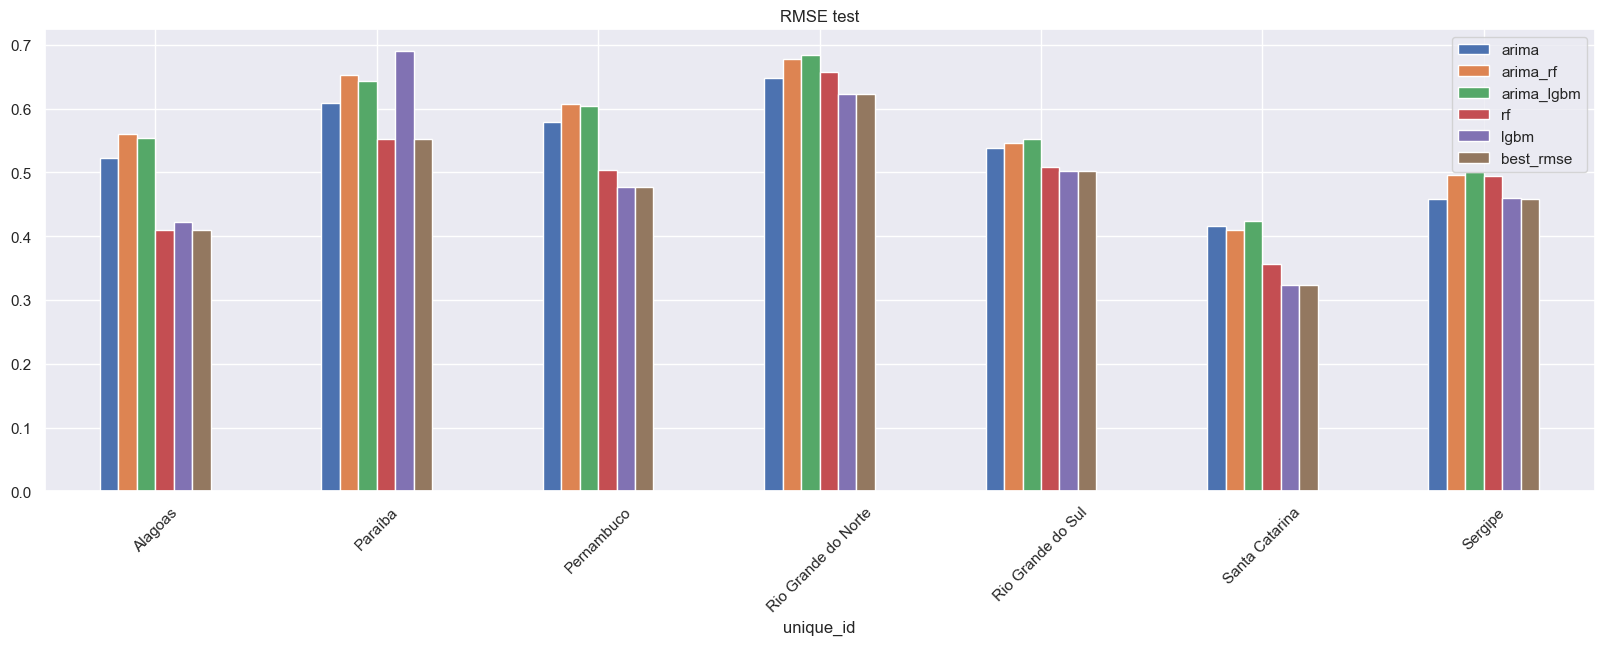

In [203]:
rmse_erros.plot.bar(x = 'unique_id',rot = 45,
                    figsize = (20,6))
plt.title('RMSE test')
plt.show()


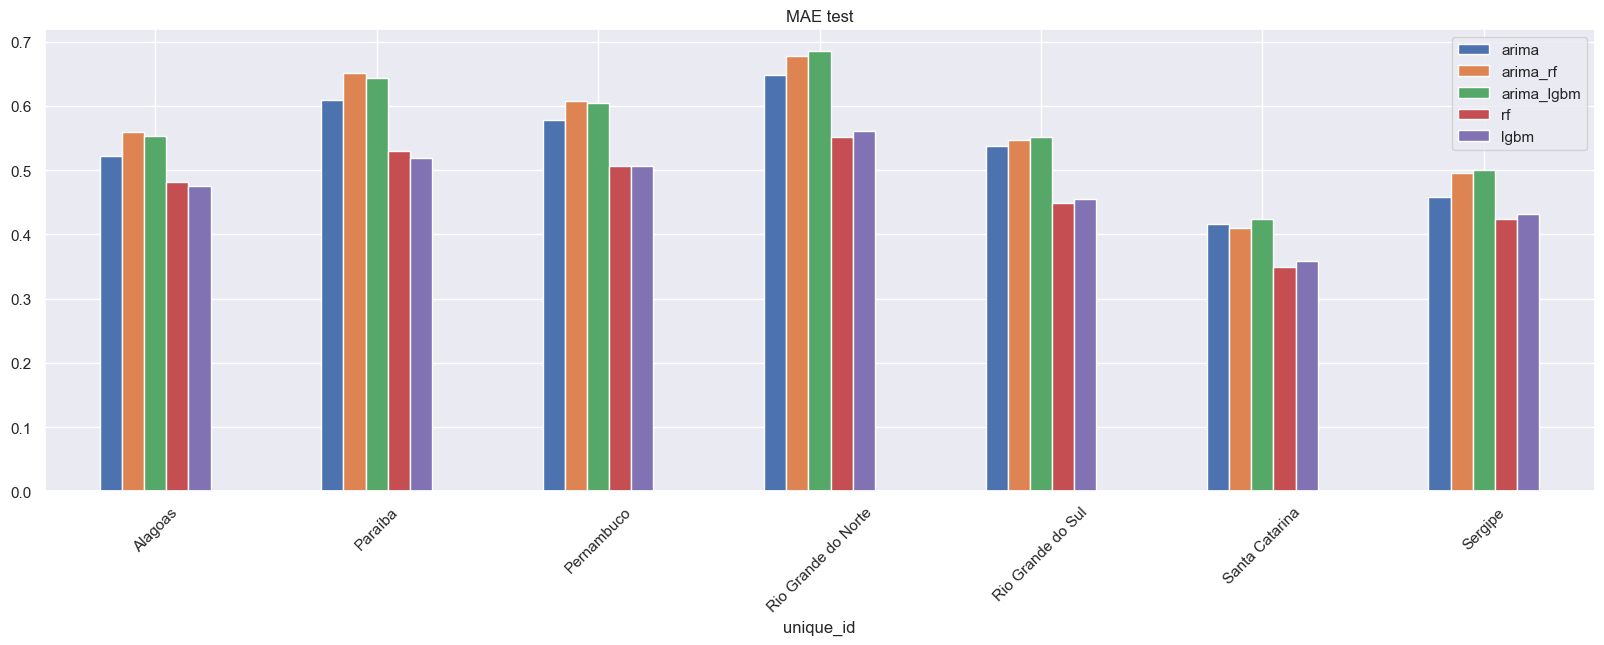

In [197]:
mae_erros.plot.bar(x = 'unique_id',rot = 45,
                    figsize = (20,6))
plt.title("MAE test")
plt.show()

In [227]:
rmse_erros['best_rmse'] = rmse_erros.drop(columns='unique_id').min(axis=1)
rmse_erros['best_model'] = rmse_erros.drop(columns='unique_id').idxmin(axis=1)

In [231]:
mae_erros['best_mae'] = mae_erros.drop(columns='unique_id').min(axis=1)
mae_erros['best_model'] = mae_erros.drop(columns='unique_id').idxmin(axis=1)

In [236]:
rmse_erros.to_csv('../data/results_forecast/rmse_erros.csv')